# Loading required libraries

In [ ]:
%%capture
! git clone https://github.com/jacobgil/vit-explain vit_explain

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from vit_explain.vit_rollout import VITAttentionRollout
from vit_explain.vit_grad_rollout import VITAttentionGradRollout

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
valid_img_path = 'dataset/2.validation/2.validation/img/00.png'
valid_mask_path = 'dataset/2.validation/2.validation/mask/00.png'

In [4]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.cvtColor(cv2.resize(cv2.imread(valid_mask_path), (224, 224)), cv2.COLOR_BGR2RGB)

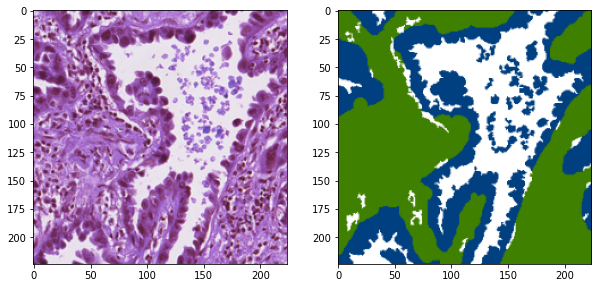

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(valid_mask)

# Pre Processing image

In [6]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [7]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [17]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    mask = cv2.resize(mask, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for
                 x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if
                 '32' in x and 'deit' not in x]
model_weights.sort()
model_weights

# Demonstrating attention-rollout and attention-grad-rollout for the best model

In [9]:
model = timm.create_model('vit_base_patch32_224', pretrained = False, num_classes = 3,
                          drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

In [10]:
model.load_state_dict(torch.load(f='../models/model_vit_base_patch32_224_2.pth', map_location=device))

<All keys matched successfully>

In [11]:
%%capture
model.eval()

In [12]:
target_layer = [model.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [13]:
valid_img_tensor = preprocess_image(valid_img, ).to(device)

## 01. Attention Rollout

In [14]:
attention_rollout = VITAttentionRollout(model, head_fusion='mean', discard_ratio=0.9)

In [15]:
mask_0 = attention_rollout(valid_img_tensor)
#mask_1 = attention_rollout(valid_img_tensor)
#mask_2 = attention_rollout(valid_img_tensor)

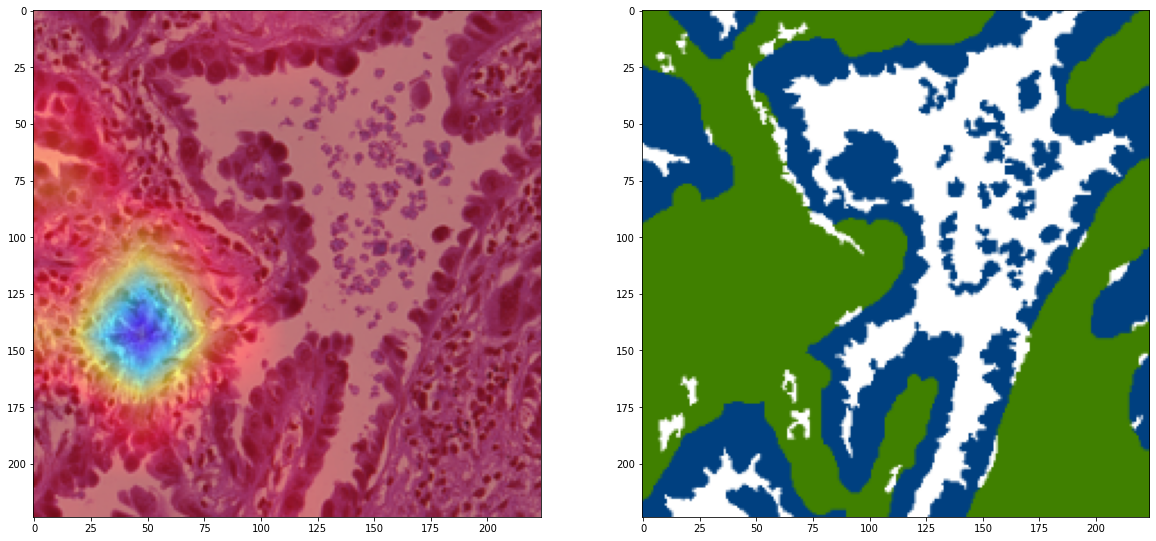

In [19]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(show_mask_on_image(valid_img, mask_0))

ax = fig.add_subplot(1, 2, 2)
plt.imshow(valid_mask)

## 02 Attention Grad Rollout

In [20]:
grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.9)

In [21]:
mask_0 = grad_rollout(valid_img_tensor, category_index=0)
mask_1 = grad_rollout(valid_img_tensor, category_index=1)
mask_2 = grad_rollout(valid_img_tensor, category_index=2)

/home/zephyr/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


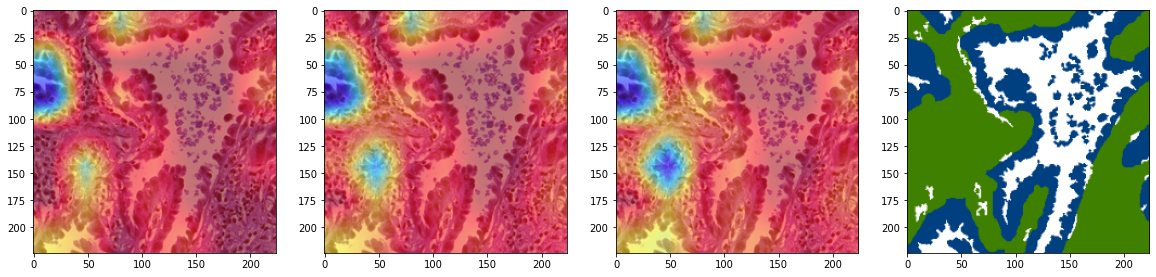

In [23]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_mask_on_image(valid_img, mask_0))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_mask_on_image(valid_img, mask_1))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_mask_on_image(valid_img, mask_2))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_mask)